## Machine Learning Class Project
Chris Reimann

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings
import tensorflow.keras
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
! pip install nltk

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

# Initialize the stopwords
stoplist = stopwords.words('english')

import nltk
import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/UChicago/ML

/content/drive/My Drive/UChicago/ML


In [6]:
import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/UChicago/ML'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/UChicago/ML/glove.6B.100d.txt
/content/drive/My Drive/UChicago/ML/glove.6B.50d.txt
/content/drive/My Drive/UChicago/ML/dev-access.csv
/content/drive/My Drive/UChicago/ML/test.csv
/content/drive/My Drive/UChicago/ML/train.csv
/content/drive/My Drive/UChicago/ML/sample_submission.csv


In [7]:
tweet = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
tweet.count()

id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [9]:
test.count()

id          3263
keyword     3237
location    2158
text        3263
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

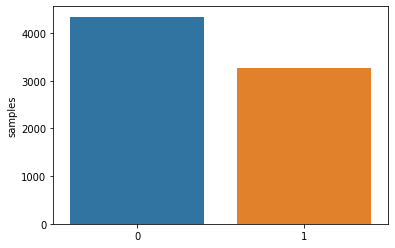

In [10]:
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

## Data Cleaning

In [11]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [12]:
def remove_URL(text): # Remove Urls
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

In [13]:
def remove_html(text): # Remove html tags
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [14]:
def remove_emoji(text): # Remove Emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [15]:
def remove_punct(text): # Remove punctuations
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))


In [16]:
!pip install pyspellchecker # Spelling Correction

     |████████████████████████████████| 1.9MB 4.0MB/s 


In [17]:
from spellchecker import SpellChecker
spell = SpellChecker()
counter=0
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
      if word in misspelled_words:
          corrected_text.append(spell.correction(word))
      else:
          corrected_text.append(word)
    return " ".join(corrected_text)
    

#df['text']=df['text'].apply(lambda x : correct_spellings(x))

## GloVe for Vectorization

In [18]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [19]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 8773.87it/s]


In [20]:
embedding_dict={}
with open('/content/drive/My Drive/UChicago/ML/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [22]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [23]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 669600.78it/s]


## Resplit data for validation

In [24]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [25]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


# MODELS

In [26]:
tweet

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [41]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
 
# create a sequence classification instance
def get_sequence(n_timesteps):
	# create a sequence of random numbers in [0,1]
	X = array([random() for _ in range(n_timesteps)])
	# calculate cut-off value to change class values
	limit = n_timesteps/4.0
	# determine the class outcome for each item in cumulative sequence
	y = array([0 if x < limit else 1 for x in cumsum(X)])
	# reshape input and output data to be suitable for LSTMs
	X = X.reshape(1, n_timesteps, 1)
	y = y.reshape(1, n_timesteps, 1)
	return X, y

In [33]:
# define LSTM
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Bidirectional,TimeDistributed
from keras.initializers import Constant

model = Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(Bidirectional(LSTM(64,recurrent_dropout=0.2, return_sequences=True)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

In [34]:
# Compile model - Binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 1)             129       
Total params: 2,118,909
Trainable params: 84,609
Non-trainable params: 2,034,300
_________________________________________________________________


In [36]:
# train LSTM
history=model.fit(X_train,y_train, epochs=10, batch_size=10, validation_data=(X_test,y_test),verbose=1)

Epoch 1/10
648/648 [==============================] - 152s 234ms/step - loss: 0.4958 - accuracy: 0.7800 - val_loss: 0.4411 - val_accuracy: 0.7966
Epoch 2/10
648/648 [==============================] - 151s 233ms/step - loss: 0.4457 - accuracy: 0.8068 - val_loss: 0.4290 - val_accuracy: 0.8176
Epoch 3/10
648/648 [==============================] - 151s 234ms/step - loss: 0.4291 - accuracy: 0.8154 - val_loss: 0.4377 - val_accuracy: 0.7964
Epoch 4/10
648/648 [==============================] - 150s 231ms/step - loss: 0.4087 - accuracy: 0.8257 - val_loss: 0.4295 - val_accuracy: 0.8143
Epoch 5/10
648/648 [==============================] - 151s 233ms/step - loss: 0.3913 - accuracy: 0.8348 - val_loss: 0.4303 - val_accuracy: 0.8072
Epoch 6/10
648/648 [==============================] - 150s 232ms/step - loss: 0.3751 - accuracy: 0.8436 - val_loss: 0.4462 - val_accuracy: 0.8176
Epoch 7/10
648/648 [==============================] - 150s 232ms/step - loss: 0.3513 - accuracy: 0.8555 - val_loss: 0.4745 -

In [37]:
model.save('BiLSTM_project_model.h5')
print("Saved model")
#model.load_weights('BiLSTM_project_model.h5')

Saved model


Text(0.5, 1.0, 'Accuracy Curves')

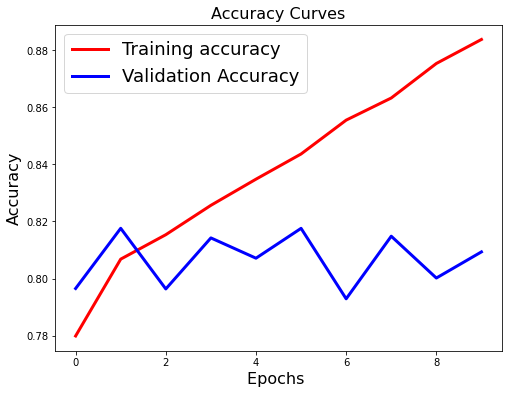

In [38]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

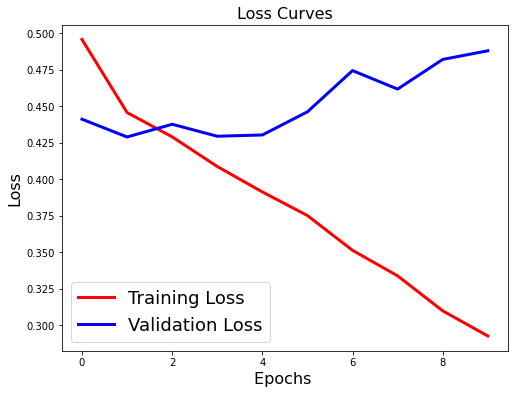

In [39]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [45]:
# evaluate LSTM
#X,y = get_sequence(n_timesteps)
#yhat = model.predict_classes(X, verbose=0)
#for i in range(n_timesteps):
	#print('Expected:', y[0, i], 'Predicted', yhat[0, i])